In [1]:
from main import *

from brainspace.gradient.embedding import DiffusionMaps
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import sys
from scipy.optimize import linear_sum_assignment

plt.rcParams['font.size'] = 18

# Simulating neuronal activity in ellipse geometry

In [4]:
N = 2500 # Number of nodes

Loading volume vertices.

In [3]:
vertices = np.load('Files/vertices_ellipse.npy').astype('float')

order = np.argsort(vertices[:, 2]) # Ordering vertices along z-axis for more structured matrices
vertices = vertices[order]
eigenmodes = np.load('Files/eigenmodes_ellipse.npy')[order]

random_ids = [1] * N + [0] * (vertices.shape[0] - N)
np.random.shuffle(random_ids)
coords = vertices[np.array(random_ids) == 1] # Node coordinates are taken randomly from 3D mesh vertices

Parameters

In [7]:
rule = 'sphere' # Hard spatial cutoff in connections
h = 0.02  # Neighborhood size (2% of major axis length)

# Dynamical parameters
g = 3     # Coupling strength
tau = 3   # Time constant

One example run.

In [8]:
rnn = RNN(N, coords, g=g, tau=tau, rule=rule, h=h)

R = rnn.forward(1000) # Neuronal firing rates

C = torch.corrcoef(R).detach().cpu().numpy() # Correlations
W = rnn.W.detach().cpu().numpy() # Connection weights
R = R.detach().cpu().numpy()

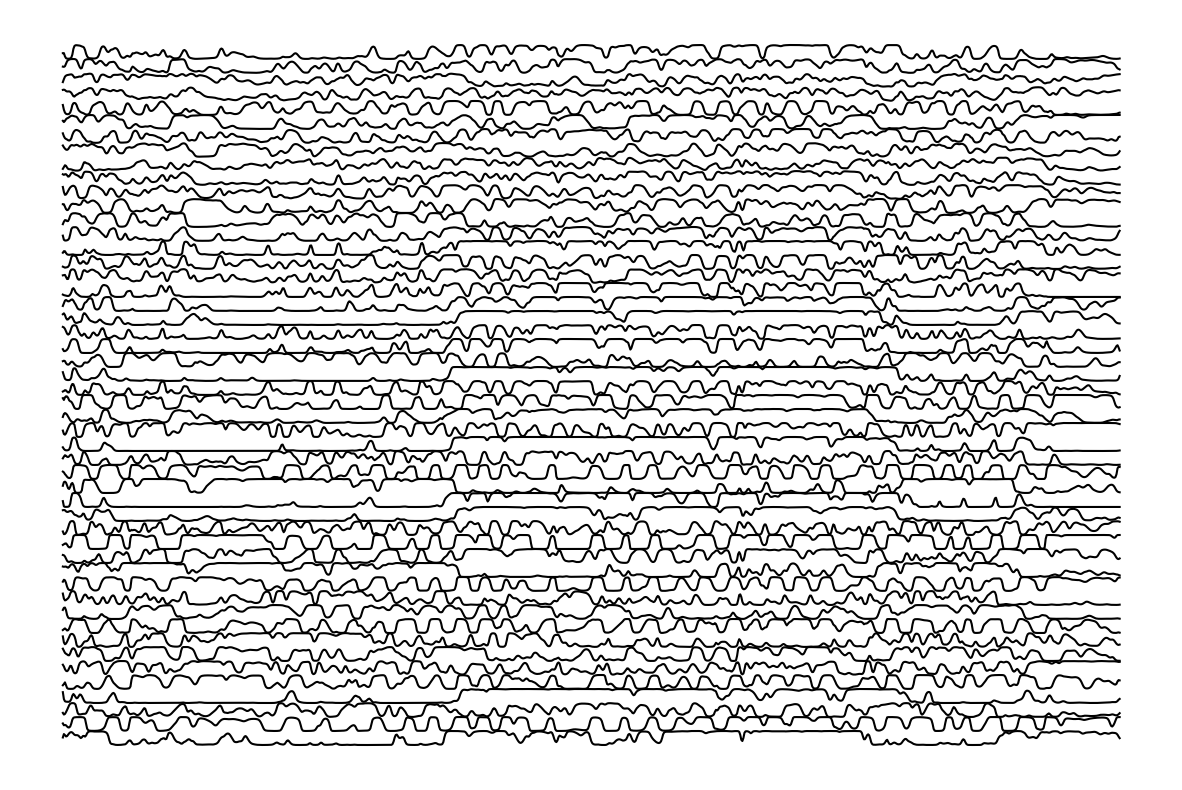

In [9]:
plt.figure(figsize=(15, 10))
for i in range(50):
    plt.plot(R[i] - 2 * i, color='black')
plt.axis('off')
plt.show()

(100.0, 0.0)

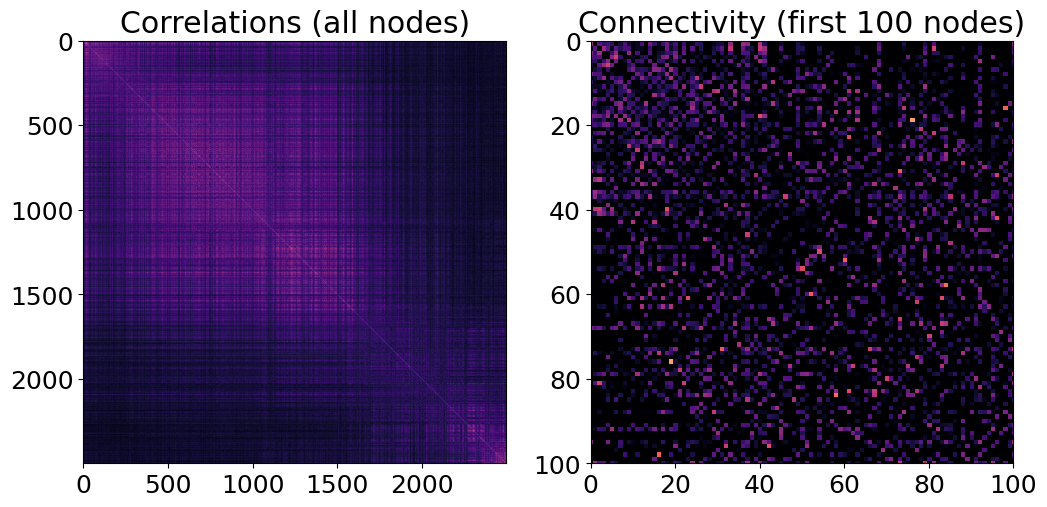

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.abs(C), cmap='magma')
ax[0].set_title('Correlations (all nodes)')
ax[1].imshow(np.abs(W + W.T), cmap='magma')
ax[1].set_title('Connectivity (first 100 nodes)')

#ax[0].set_xlim([0, 100])
#ax[0].set_ylim([100, 0])
ax[1].set_xlim([0, 100])
ax[1].set_ylim([100, 0])

#### Averaging over random connection weights and initial conditions for a given set of node coordinates

Due to high memory requirements of storing $N$ matrices of dimension $2500\times2500$, we are computing a running average here (keeping only the result in memory). We are averaging over 200 simulations; this is where `Pytorch` really comes in handy. 

Integrating over 1000 time steps and using the same parameters as defined earlier. We are taking absolute values.

In [11]:
absolute = True

C, W = np.zeros((N, N)), np.zeros((N, N))

for _ in tqdm(range(100), file=sys.stdout):
    
    rnn = RNN(N, coords, g=g, tau=tau, rule=rule, h=h)
    R = rnn.forward(1000)
    
    c = torch.corrcoef(R).detach().cpu().numpy() # Correlations
    w = rnn.W.detach().cpu().numpy() # Connection weights

    if absolute:
        C = (np.abs(C) * (i / (1 + i))) + (np.abs(c) * (1 / (i + 1)))
        W = (np.abs(W) * (i / (1 + i))) + (np.abs(w) * (1 / (i + 1)))
    else:
        C = (C * (i / (1 + i))) + (c * (1 / (i + 1)))
        W = (W * (i / (1 + i))) + (w * (1 / (i + 1)))

C[np.diag_indices(C.shape[0])] = 0 # Removing diagonal

100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


#### Visualizing correlations and symmetrized connectivity weights

In [12]:
from matplotlib.colors import LogNorm

Text(0.5, 1.0, 'Average connectivity')

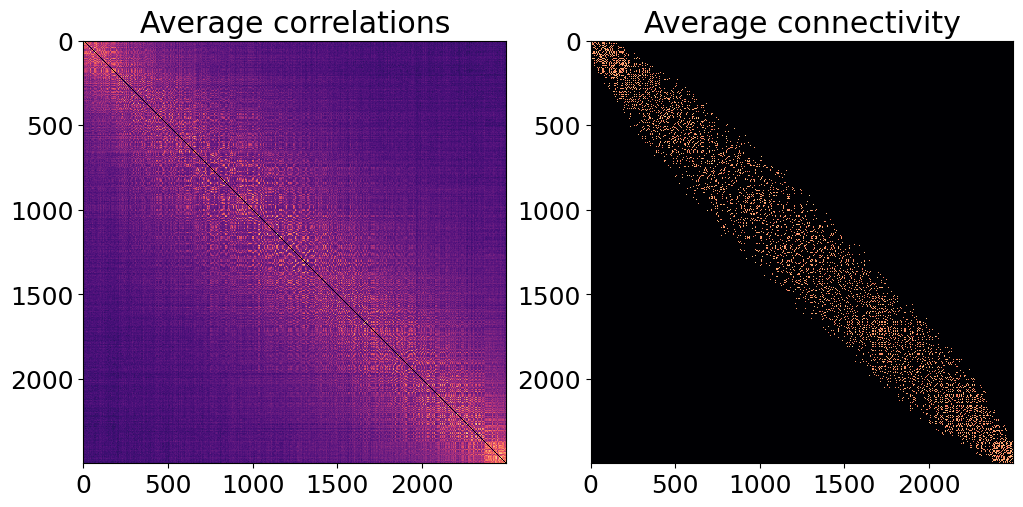

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(C + 1, cmap='magma', interpolation='None', norm=LogNorm())
ax[0].set_title('Average correlations')
ax[1].imshow(0.5 * (W + W.T) + 1., cmap='magma', interpolation='None', norm=LogNorm())
ax[1].set_title('Average connectivity')

#ax[0].set_xlim([0, 50])
#ax[0].set_ylim([50, 0])
#ax[1].set_xlim([0, 50])
#ax[1].set_ylim([50, 0])

# Computing diffusion gradient

Using a Diffusion Map embedding, introduced in this paper: https://www.pnas.org/doi/abs/10.1073/pnas.0500334102.

Has been extensively used in neuroscience literature since this paper: https://www.pnas.org/doi/abs/10.1073/pnas.1608282113.

#### Extracting functional and structural gradients

In [14]:
N_modes = 50

map = DiffusionMaps(n_components=N_modes)
embedding_functional = map.fit_transform(C)

map = DiffusionMaps(n_components=N_modes, alpha=0)
embedding_structural = map.fit_transform(0.5 * (W + W.T))

modes_functional, modes_structural = [], []
for i in range(N_modes):
    modes_functional.append(embedding_functional[:, i].flatten())
    modes_structural.append(embedding_structural[:, i].flatten())

#### Structural and functional gradient correspondence

In [15]:
# Correlating structural and functional modes
corrs = np.zeros((N_modes, N_modes))
for i in range(N_modes):
    for j in range(N_modes):
        corrs[i, j] = pearsonr(modes_functional[i], modes_structural[j])[0]

# Reordering modes to maximize their correspondence
cost_matrix = 1 - np.abs(corrs)
_, mapping = linear_sum_assignment(cost_matrix)

# Generating reordered similarity matrix
corrs = np.zeros((N_modes, N_modes))
for i in range(N_modes):
    for j in range(N_modes):
        corrs[i, j] = pearsonr(modes_functional[i], modes_structural[mapping[j]])[0]

Visualizing reordered similarity matrix.

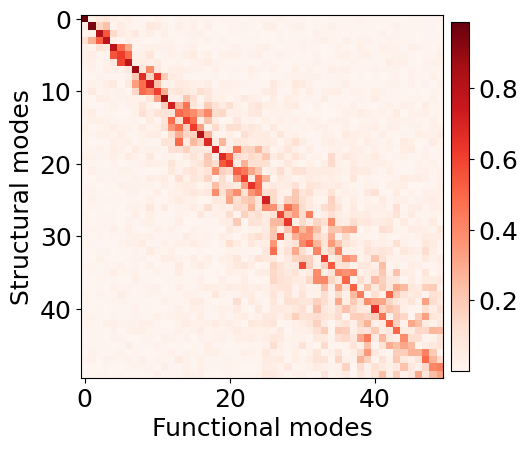

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
cax = plt.imshow(np.abs(corrs), cmap='Reds')
plt.xlabel('Functional modes')
plt.ylabel('Structural modes')
#cbar = fig.colorbar(cax, ax=ax, fraction=0.04, pad=0.02)
plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)

In [17]:
corrs_structure_function = np.copy(corrs)

# Comparison with geometric eigenmodes

In [18]:
geometric_modes = eigenmodes[np.array(random_ids) == 1, :].T # Subsampling vertices, where network nodes are located
geometric_modes = geometric_modes[1:, :] # Excluding first mode (artifact)

In [19]:
corrs = np.zeros((N_modes, N_modes))
for i in range(N_modes):
    for j in range(N_modes):
        corrs[i, j] = pearsonr(geometric_modes[i], modes_functional[j])[0]

cost_matrix = 1 - np.abs(corrs)
_, mapping = linear_sum_assignment(cost_matrix)

corrs = np.zeros((N_modes, N_modes))
for i in range(N_modes):
    for j in range(N_modes):
        corrs[i, j] = pearsonr(geometric_modes[i], modes_functional[mapping[j]])[0]

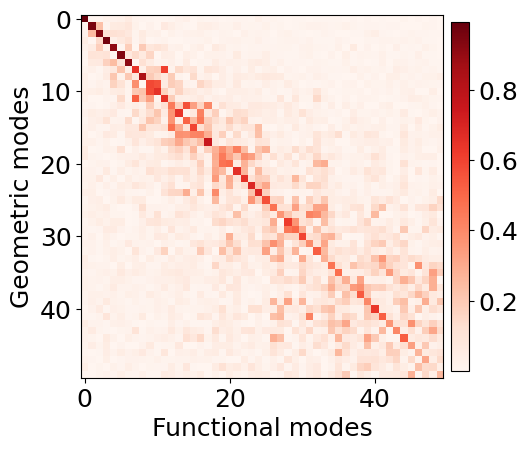

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
cax = plt.imshow(np.abs(corrs), cmap='Reds')
plt.xlabel('Functional modes')
plt.ylabel('Geometric modes')
#cbar = fig.colorbar(cax, ax=ax, fraction=0.04, pad=0.02)
plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
#plt.savefig('heart_modes_comparison.png')

Plotting functional gradients, ordered by similarity with geometric gradients.

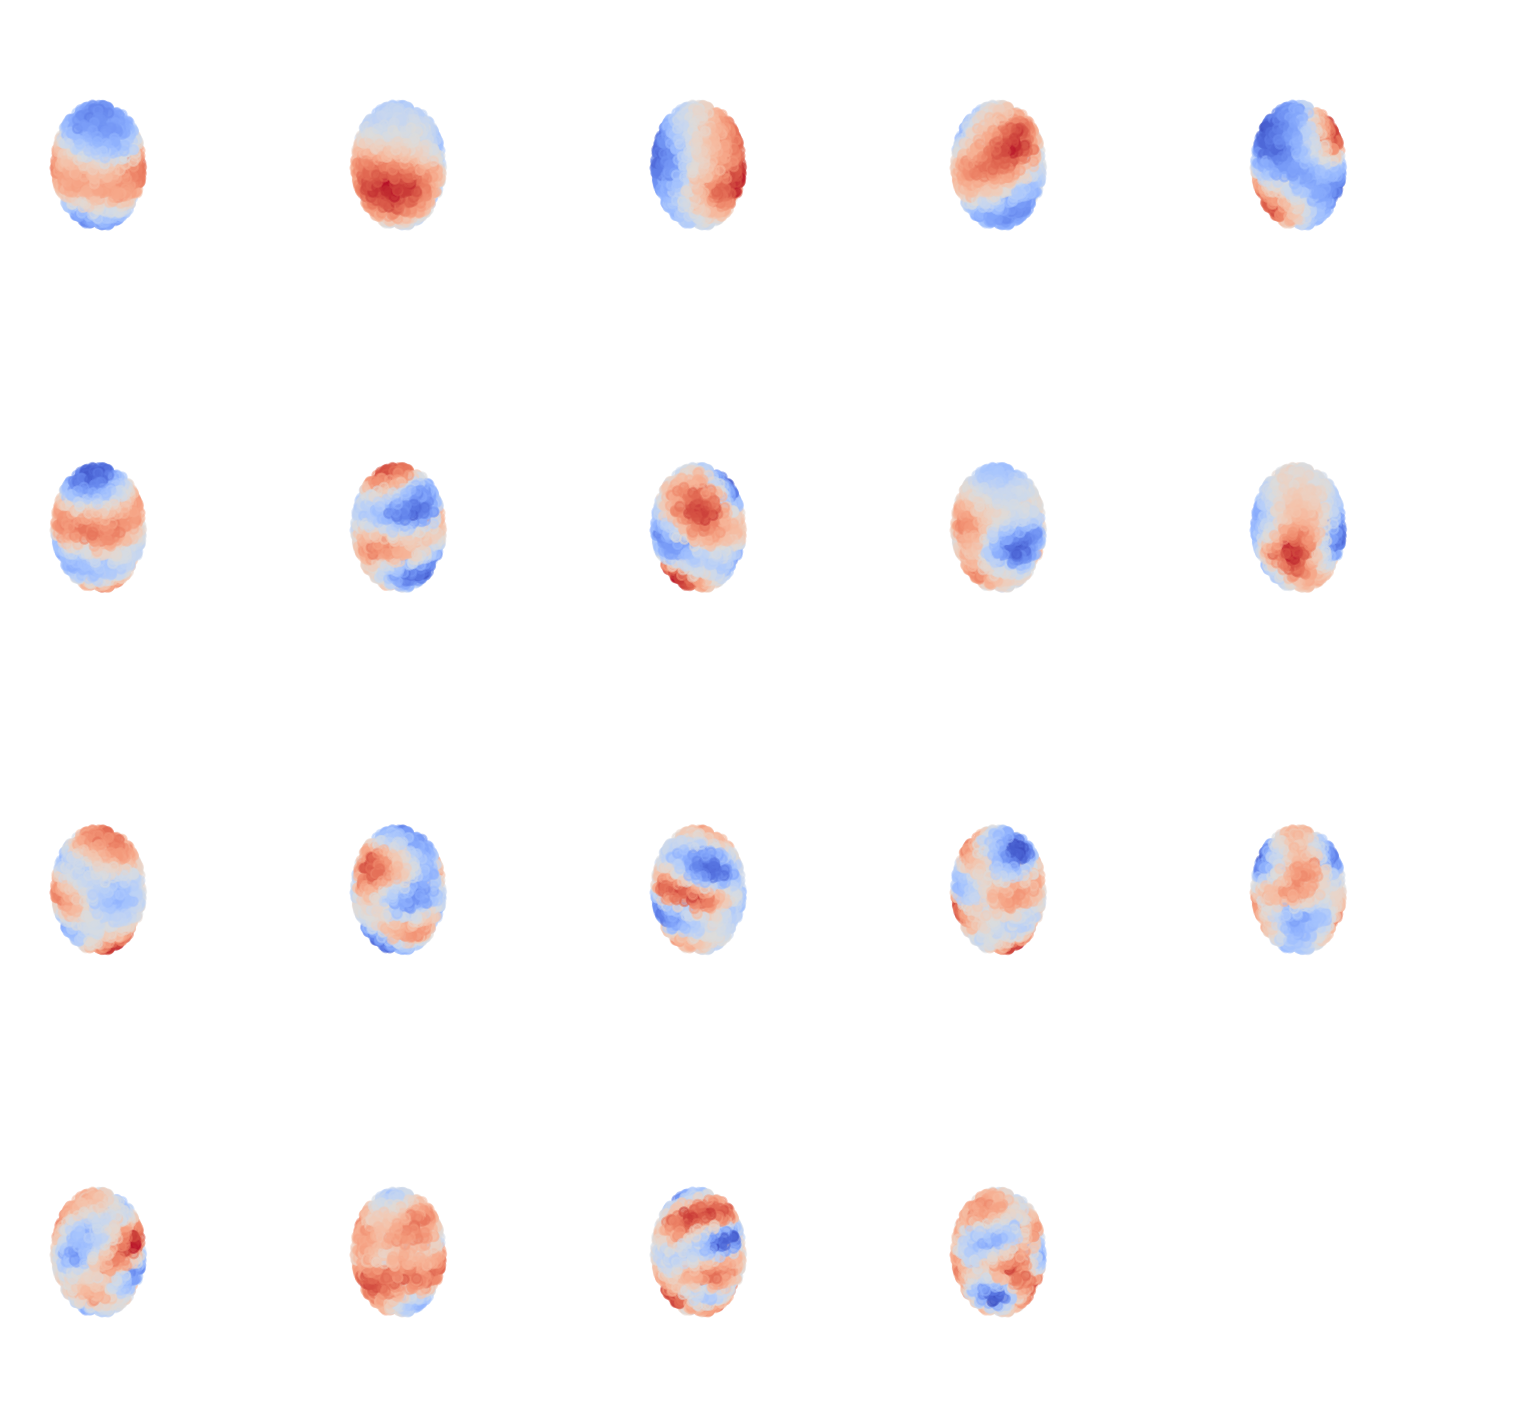

In [21]:
fig, axes = plt.subplots(4, 5, subplot_kw={"projection": "3d"}, figsize=(10, 10), dpi=150)

for i in range(1, 20):
    ax = axes.flatten()[i - 1]
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=np.sign(corrs[i, i]) * modes_functional[mapping[i]], alpha=0.5, cmap='coolwarm')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_axis_off()
    #ax.set_frame_on(False)
    
axes[3, 4].set_axis_off()
#axes[3, 4].set_frame_on(False)

plt.tight_layout(pad=0)
#plt.savefig('Figures/eigenhearts_gradients.png')
plt.show()

In [22]:
corrs_geometry_function = np.copy(corrs)

# Plotting correlation decay with mode \#

(0.0, 1.0)

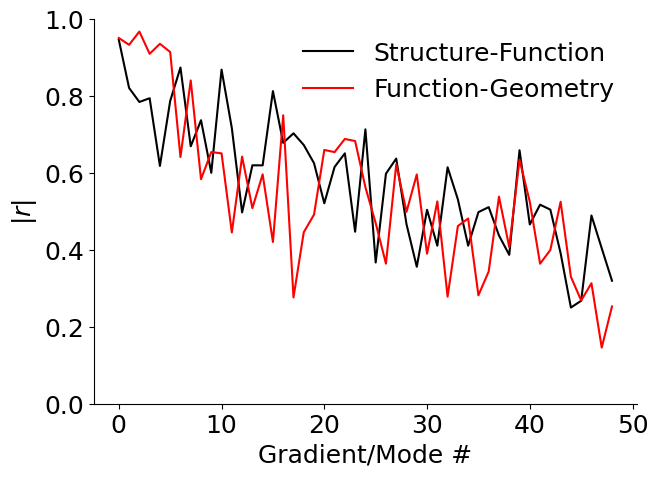

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(np.abs(corrs_structure_function[np.diag_indices(corrs.shape[0])])[1:], color='black', label='Structure-Function')
ax.plot(np.abs(corrs_geometry_function[np.diag_indices(corrs.shape[0])])[1:], color='red', label='Function-Geometry')

ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('Gradient/Mode #')
plt.ylabel(r'$|r|$')
plt.legend(frameon=False)
plt.ylim([0, 1])